In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use(['seaborn-ticks', 'seaborn-talk'])
import cartopy.crs as ccrs
import cmocean

import numpy as np
import pandas as pd 
import xarray as xr

import logging
logging.basicConfig(level=logging.WARNING)
import warnings; warnings.simplefilter('ignore')


/Users/daniel/anaconda/lib/python3.5/site-packages/xarray/core/formatting.py:16: FutureWarning: The pandas.tslib module is deprecated and will be removed in a future version.
  from pandas.tslib import OutOfBoundsDatetime


# Meeting - June 28th, 2017

I agreed to visit Harvard and chat with Lu Shen about some of my preliminary results on this project. To help prepare for this work, he asked if I could prepare a few analyses, so I went ahead and did so.

## $\mathrm{PM}_{2.5}$ versus Meteorology

Lu asked if I could plot $\mathrm{PM}_{2.5}$ versus temperature for the winter and summer. I can supplement this by also looking at precipitation and relative humidity.

In [138]:
data = (
    xr.open_dataset("../data/processed/lu_2017/fgm.all_cases.usa_subset.nc")
)

season = 'DJF'
y = 'PM25'
x = 'TEMP'
corr_str = "{}_{}".format(y, x)
data_season = data.where(data['time.season'] == season, drop=True)[[x, y]]
data_season


<xarray.Dataset>
Dimensions:  (dec: 3, ic: 5, lat: 15, lon: 24, pol: 3, time: 89)
Coordinates:
  * ic       (ic) int64 1 2 3 4 5
    cs       int64 30
  * time     (time) datetime64[ns] 1981-01-01 1981-02-01 1981-12-01 ...
    lev      float64 992.6
  * pol      (pol) object 'REF' 'P37' 'P45'
  * lon      (lon) float64 -125.0 -122.5 -120.0 -117.5 -115.0 -112.5 -110.0 ...
  * dec      (dec) object '1980-2010' '2035-2065' '2085-2115'
  * lat      (lat) float64 23.68 25.58 27.47 29.37 31.26 33.16 35.05 36.95 ...
Data variables:
    TEMP     (pol, ic, dec, time, lat, lon) float64 291.4 291.0 291.0 291.2 ...
    PM25     (pol, ic, dec, time, lat, lon) float64 25.17 27.98 26.65 19.69 ...
Attributes:
    History:  Generated by 09_lu_shen_reproduction.ipynb (Apr 19, 2017 13:49)\n

### Regression Slopes

First we calculate for each ensemble member separately.

In [139]:
from air_quality.analysis import regress_fields

ens_data = regress_fields(data_season,#.sel(pol='REF', ic=1, dec='1980-2010'),
                          x, y)

**Save to disk**

In [140]:
output_fn = "../data/processed/lu_2017/{}-vs-{}.fgm.usa.ensemble.{}.nc".format(
    y, x, season
)

ens_data.to_netcdf(output_fn)

syncing


---

Now we want to repeat the calculation, but we'll pool our data for all 5 ensemble members for each case. To do this, we're just going to concatenate each value for **ic** along the *time* dimension.

In [141]:
ics = []
nt = len(data_season.time)
for i, ic in enumerate(data_season.ic):
    indices = np.arange(i*nt, (i+1)*nt)
    _ic = (
        data_season.sel(ic=ic)
        .assign(time=indices)
    )
    ics.append(_ic)
data_season_pooled = xr.concat(ics, 'time')
data_season_pooled

<xarray.Dataset>
Dimensions:  (dec: 3, lat: 15, lon: 24, pol: 3, time: 445)
Coordinates:
    cs       int64 30
    lev      float64 992.6
  * pol      (pol) object 'REF' 'P37' 'P45'
  * lon      (lon) float64 -125.0 -122.5 -120.0 -117.5 -115.0 -112.5 -110.0 ...
  * dec      (dec) object '1980-2010' '2035-2065' '2085-2115'
  * lat      (lat) float64 23.68 25.58 27.47 29.37 31.26 33.16 35.05 36.95 ...
    ic       (time) int64 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 ...
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
Data variables:
    TEMP     (pol, dec, time, lat, lon) float64 291.4 291.0 291.0 291.2 ...
    PM25     (pol, dec, time, lat, lon) float64 25.17 27.98 26.65 19.69 ...
Attributes:
    History:  Generated by 09_lu_shen_reproduction.ipynb (Apr 19, 2017 13:49)\n

In [142]:
from air_quality.util import flatten_times

data_season_pooled = flatten_times(data_season)

In [143]:
pooled_data = regress_fields(data_season_pooled,
                             x, y)
pooled_data

<xarray.Dataset>
Dimensions:            (dec: 3, lat: 15, lon: 24, pol: 3, time: 445)
Coordinates:
    cs                 int64 30
    lev                float64 992.6
    ic                 (time) int64 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 ...
  * time               (time) datetime64[ns] 1981-01-01 1981-02-01 ...
  * lon                (lon) float64 -125.0 -122.5 -120.0 -117.5 -115.0 ...
  * pol                (pol) object 'REF' 'P37' 'P45'
  * dec                (dec) object '1980-2010' '2035-2065' '2085-2115'
  * lat                (lat) float64 23.68 25.58 27.47 29.37 31.26 33.16 ...
Data variables:
    TEMP               (time, lon, pol, dec, lat) float64 291.4 290.5 289.7 ...
    PM25               (time, lon, pol, dec, lat) float64 25.17 26.31 26.92 ...
    r_PM25_TEMP        (lon, pol, dec, lat) float64 0.3622 0.4279 0.4779 ...
    p_PM25_TEMP        (lon, pol, dec, lat) float64 3.07e-15 3.076e-21 ...
    m_PM25_TEMP        (lon, pol, dec, lat) float64 3.809 5.577 7.165 10.2

**Save to disk**

In [144]:
output_fn = "../data/processed/lu_2017/{}-vs-{}.fgm.usa.pooled.{}.nc".format(
    y, x, season
)

pooled_data.to_netcdf(output_fn)

syncing


### Plots

Compare the slopes for each ensemble member versus the pooled data for each ensemble

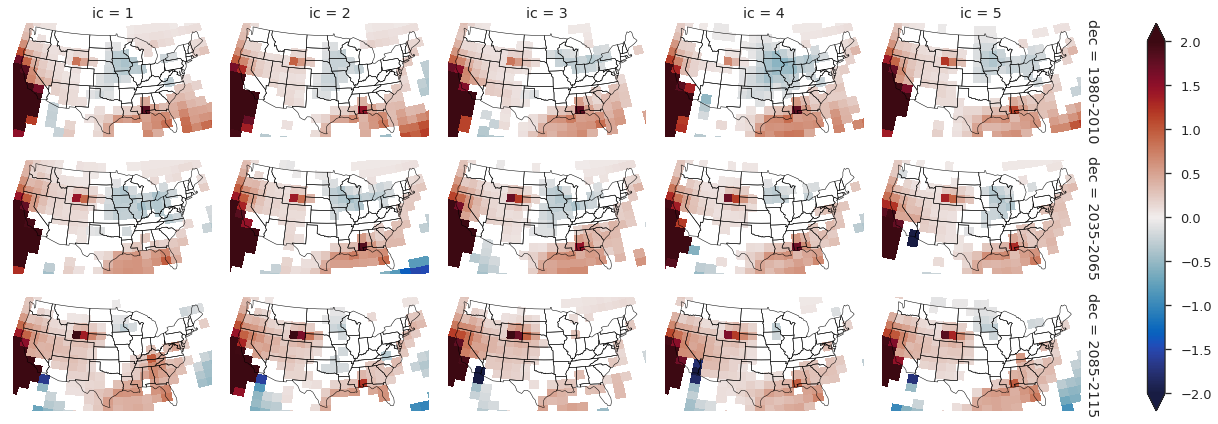

In [147]:
from air_quality.plot import add_usa_states, STATE_PROJ, STATE_EXTENT

cmap_kws = dict(
    vmin=-2., vmax=2., cmap=cmocean.cm.balance
)
p_thresh = 0.05

_p_ens = (
    ens_data
    ['m_'+corr_str].where(ens_data['p_'+corr_str] <= p_thresh)
    .sel(pol='REF')
)
g = _p_ens.plot.pcolormesh(x='lon', y='lat', col='ic', row='dec', 
                           infer_intervals=True, transform=ccrs.PlateCarree(),
                           aspect=1.8, size=2.,
                           subplot_kws=dict(
                               projection=STATE_PROJ, aspect='auto'
                           ), **cmap_kws)
for ax in g.axes.ravel():
    ax.set_extent(STATE_EXTENT)
    ax = add_usa_states(ax, facecolor='none', lw=0.5)
    ax.outline_patch.set_visible(False)
    
plt.savefig("../figs/lu_2017/comparison_062817/{}-vs-{}.slopes.fgm.usa.ensemble.{}.pdf"
            .format(y, x, season ),
            transparent=True, bbox_inches='tight')

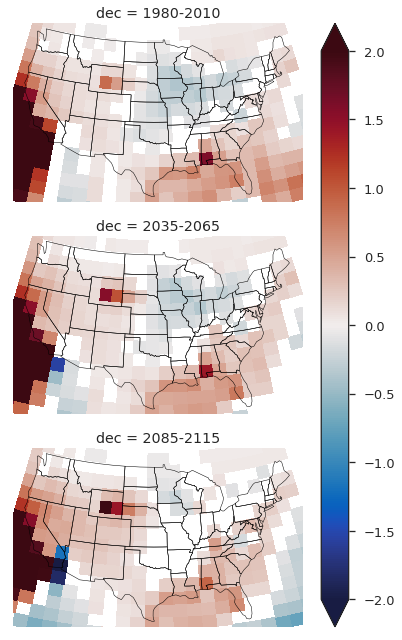

In [148]:
_p_pooled = (
    pooled_data
    ['m_'+corr_str].where(pooled_data['p_'+corr_str] <= p_thresh)
    .sel(pol='REF',)
)
g = _p_pooled.plot.pcolormesh(x='lon', y='lat', row='dec', 
                              infer_intervals=True, transform=ccrs.PlateCarree(),
                              aspect=1.5, size=3.,
                              subplot_kws=dict(
                                  projection=STATE_PROJ, aspect='auto'
                              ), **cmap_kws)
for ax in g.axes.ravel():
    ax.set_extent(STATE_EXTENT)
    ax = add_usa_states(ax, facecolor='none', lw=0.5)
    ax.outline_patch.set_visible(False)
    
plt.savefig("../figs/lu_2017/comparison_062817/{}-vs-{}.slopes.fgm.usa.pooled.{}.pdf"
            .format(y, x, season ),
            transparent=True, bbox_inches='tight')

---

## Fit Models

In [70]:
from air_quality.models.shen2017 import Shen2017Model

cell_name = 'cell'
predictand = 'PM25'
predictors = ['TEMP', 'RH', 'PRECIP', 'U', 'V']
dilon, dilat = 6, 4

obs_data = xr.open_dataset("../data/processed/lu_2017/obs.usa_subset.nc")
# Mask out cells where we have no PRECIP data
mask = np.isnan(obs_data.PRECIP.isel(time=0)).rename("CONUS_MASK")

month = 0
obs_model = Shen2017Model(
    obs_data, month=month, mask=mask,
    verbose=True, n_predictors=3, hybrid=True, cross_validate=True
)

In [71]:
obs_data

<xarray.Dataset>
Dimensions:  (lat: 12, lon: 24, time: 180)
Coordinates:
  * lat      (lat) float32 22.5 25.0 27.5 30.0 32.5 35.0 37.5 40.0 42.5 45.0 ...
  * lon      (lon) float32 -125.0 -122.5 -120.0 -117.5 -115.0 -112.5 -110.0 ...
  * time     (time) datetime64[ns] 1999-01-01 1999-02-01 1999-03-01 ...
Data variables:
    RH       (time, lat, lon) float64 80.5 77.69 76.56 76.44 73.38 73.12 ...
    U        (time, lat, lon) float64 -5.5 -4.562 -3.375 -2.0 -0.875 0.5 ...
    TEMP     (time, lat, lon) float64 17.59 17.4 17.27 17.89 18.35 18.7 ...
    V        (time, lat, lon) float64 -4.188 -4.5 -4.938 -5.125 -5.125 ...
    PRECIP   (time, lat, lon) float32 nan nan nan nan nan nan nan nan nan ...
    PM25     (time, lat, lon) float32 nan nan nan nan nan nan nan nan nan ...

In [54]:
obs_model.fit_parallel(30)

Loop over all grid cells: 100%|██████████| 288/288 [02:53<00:00,  1.66it/s]all grid cells:   0%|          | 1/288 [00:00<02:12,  2.17it/s]Loop over all grid cells:  35%|███▍      | 100/288 [00:10<00:18,  9.99it/s]


Iterate over grid cell models:   0%|          | 0/288 [00:00<?, ?it/s]Iterate over grid cell models: 100%|██████████| 288/288 [00:00<00:00, 402787.45it/s]


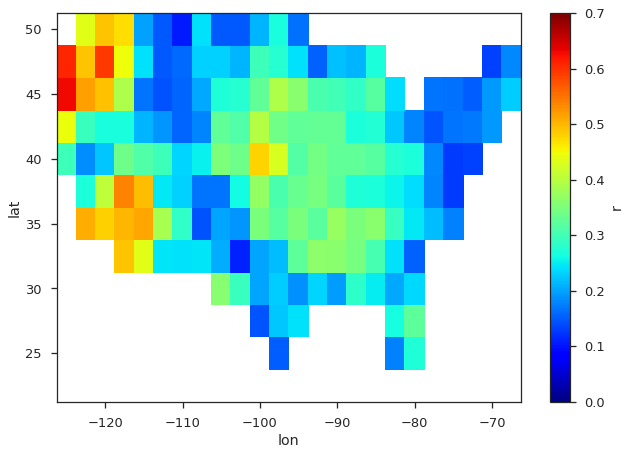

In [56]:
r = obs_model.get_result_stat('r', result=False)['r']
(r**2).plot.pcolormesh(vmin=0., vmax=0.7, cmap='jet')

In [57]:
obs_model.to_pickle("test.p")

### Obs models

In [ ]:
from air_quality.models.shen2017 import Shen2017Model

from itertools import product
for case, month in product(['local', 'hybrid'],
                           range(1, 13)):
    print(case, month)
    hybrid = case == 'hybrid'
    obs_model = Shen2017Model(
        obs_data, month=month, mask=mask,
        verbose=True, n_predictors=3, hybrid=hybrid, cross_validate=True
    )
    obs_model.fit_parallel(30)
    obs_model.to_pickle("../data/processed/lu_2017/models/obs.{case}.{month}.p"
                        .format(case=case, month=month))

### FGM Models

In [64]:
grid_stack = ['lat', 'lon']
cell_name = 'cell'
predictand = 'PM25'
predictors = ['TEMP', 'RH', 'PRECIP', 'U', 'V']
dilon, dilat = 6, 4

import pyresample

data_model = xr.open_dataset("../data/processed/lu_2017/fgm.all_cases.usa_subset.nc")
data_model = data_model.sel(pol='REF', dec='1980-2010', ic=3)

lon_obs2d, lat_obs2d = np.meshgrid(obs_data.lon.values, obs_data.lat.values)
obs_def = pyresample.geometry.SwathDefinition(lons=lon_obs2d, lats=lat_obs2d)

lon_mod2d, lat_mod2d = np.meshgrid(data_model.lon.values, data_model.lat.values)
mod_def = pyresample.geometry.SwathDefinition(lons=lon_mod2d, lats=lat_mod2d)

from air_quality.util import model_to_obs_grid
coords = {'lon': obs_data.lon, 'lat': obs_data.lat, 'time': data_model.time}
data_model_rs = model_to_obs_grid(data_model, obs_def, mod_def, coords)

PM25
(359, 12, 24)
TEMP
(359, 12, 24)
PRECIP
(359, 12, 24)
RH
(359, 12, 24)
U
(359, 12, 24)
V
(359, 12, 24)


In [ ]:
from itertools import product
for case, month in product(['local', 'hybrid'],
                           range(1, 13)):
    print(case, month)
    hybrid = case == 'hybrid'
    model_model = Shen2017Model(
        data_model_rs, month=month, mask=mask,
        verbose=True, n_predictors=3, hybrid=hybrid, cross_validate=True
    )
    model_model.fit_parallel(30)
    model_model.to_pickle("../data/processed/lu_2017/models/fgm_test.{case}.{month}.p"
                          .format(case=case, month=month))

## Model $r^2$

The other thing that Lu and Loretta asked to see was the cross-validated $r^2$ for each of my fitted models.

In [28]:
import pickle
from itertools import product

# src = 'obs' # 'fgm_test'
# case = 'local' # 'hybrid'
month = 1

rs = []
for src, case in product(['obs', ],
                         ['local', 'hybrid']):
    fn = "../data/processed/lu_2017/models/{}.{}.{}.p".format(src, case, month)
    print(fn)
    with open(fn, 'rb') as f:
        model = pickle.load(f)
        r = model.get_result_stat('r', result=False)
        r['case'] = case
        r['src'] = src
        rs.append(r)
rs = xr.auto_combine(rs, 'case')

../data/processed/lu_2017/models/obs.local.1.p


Iterate over grid cell models: 100%|██████████| 288/288 [00:00<00:00, 477643.16it/s]


../data/processed/lu_2017/models/obs.hybrid.1.p


Iterate over grid cell models: 100%|██████████| 288/288 [00:00<00:00, 676349.13it/s]


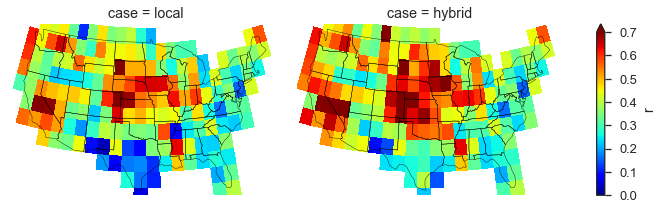

In [29]:
rsq = rs['r']**2

from air_quality.plot import STATE_PROJ, add_usa_states, PLATE_CARREE

g = rsq.plot.pcolormesh(x='lon', y='lat', col='case', col_wrap=2,
                         vmin=0, vmax=0.7, cmap='jet',
                         size=3., aspect=1.5,
                         transform=PLATE_CARREE,
                         subplot_kws=dict(
                             projection=STATE_PROJ, aspect='auto'
                         ))
for ax in g.axes.ravel():
    ax = add_usa_states(ax, facecolor='none')
    ax.outline_patch.set_visible(False)

## Model Predictors

Which predictors are included for which grid cells?

In [69]:
import pickle

src = 'fgm_test'
case = 'local' # 'hybrid'
month = 1

fn = "../data/processed/lu_2017/models/{}.{}.{}.p".format(src, case, month)
print(fn)
with open(fn, 'rb') as f:
    model = pickle.load(f)
    

../data/processed/lu_2017/models/fgm_test.local.1.p


OSError: No such file or directory

Iterate over grid cell models: 100%|██████████| 288/288 [00:00<00:00, 2653.14it/s]


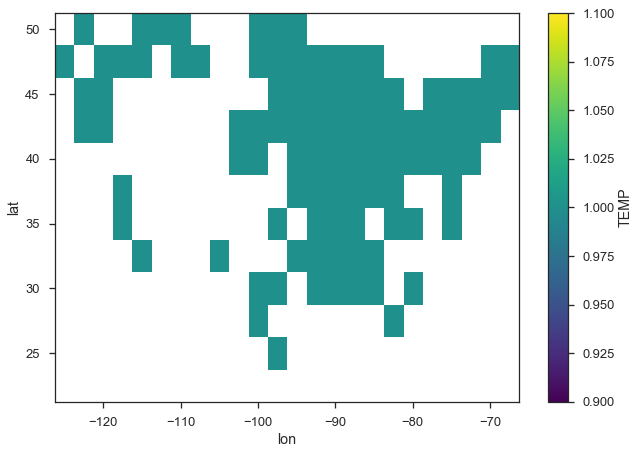

In [57]:
all_predictors = model.predictors[:]
if case == 'hybrid':
    all_predictors.extend(['S_1', 'S_2'])

predictors_ds = model.data.copy().drop(model.predictors)
ref_field = predictors_ds[model.predictand].isel(time=0)
for predictor in all_predictors:
    predictors_ds[predictor] = (ref_field.dims, np.zeros_like(ref_field.values)*np.nan)

for gcr, gcf in model._gcr_gcf_iter:
    if gcr is None:
        continue
    
    _x = getattr(gcr, 'model_predictors')
    for predictor in all_predictors:
        if predictor in _x:
            _attr_vals = predictors_ds[predictor].values[gcf.ilat, gcf.ilon] = 1.

predictors_ds['TEMP'].plot.imshow()